In [1]:
import xml.etree.cElementTree as ET
import urllib2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

Enable IPython to display matplotlib graphs and select style

In [2]:
%matplotlib inline
plt.style.use('ggplot')

Setup parameters

In [3]:
USER = 'banzayats'
MINDATE='2016-01-01'
MAXDATE='2016-12-31'

In [4]:
def get_gamedata(user, mindate, maxdate):
    dataframe = pd.DataFrame(columns=('Name', 'Length', 'Date', 'Location', 'Players', 'Winner'))
    API_LINK = 'https://boardgamegeek.com/xmlapi2/plays'
    page = 1
    end = False
    while not end:
        url = '{0}?username={1}&mindate={2}&maxdate={3}&page={4}'.format(API_LINK, user, mindate, maxdate, page)
        tree = ET.ElementTree(file=urllib2.urlopen(url))
        plays = tree.getroot()
        if len(plays) < 100:
            end = True
        for i,play in enumerate(plays.findall(".//play[@quantity='1']")):
            length = play.attrib['length']
            date = play.attrib['date']
            location = play.attrib['location']
            name = play[0].attrib['name'].encode("utf-8")
            players = len(play.find('players').findall('player'))
            # Getting winners
            winners = play.findall(".//player[@win='1']")
            if len(winners) > 1:
                winner = "Team"
            elif len(winners) == 0:
                winner = "No-one"
            else:
                winner = winners[0].attrib['name']
            # Writing dataframe
            pointer = i + 100 * (page - 1)
            dataframe.loc[pointer] = [name, length, date, location, players, winner]
        page += 1
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    return dataframe

In [5]:
df = get_gamedata(USER, MINDATE, MAXDATE)
df.head()

,Name,Length,Date,Location,Players,Winner
0,7 Wonders Duel,35,2016-12-28,Home,2.0,Vadim
1,Runebound (Third Edition),220,2016-12-27,Dima's home,3.0,No-one
2,Star Realms,25,2016-12-27,Dima's home,2.0,Vadim
3,7 Wonders Duel,40,2016-12-25,Home,2.0,Vadim
4,Mysterium,35,2016-12-25,Home,3.0,Team


In [6]:
df.shape

(339, 6)

In [7]:
df['Length'] = df['Length'].astype(int)
df.dtypes

Name                object
Length               int64
Date        datetime64[ns]
Location            object
Players            float64
Winner              object
dtype: object

In [8]:
plays = df[['Name','Length','Date']]
games_group = plays.groupby('Name')

games_count = pd.DataFrame({'Count' : plays.groupby( ['Name'] ).size()}).reset_index()

games_length = games_group.sum().reset_index()

# Concatenating two tables and convert game to hours
summary = pd.concat([games_count, games_length['Length'].apply(lambda x: x*1/60.0)], axis=1)

# The rank is calculated as the product of the number of games for the duration
summary['Rank'] = summary.Count * summary.Length
summary.sort_values('Rank', ascending=False).reset_index()

,index,Name,Count,Length,Rank
0,5,BattleLore (Second Edition),23,34.166667,785.833333
1,35,Race for the Galaxy,30,23.166667,695.000000
2,7,Bruges,22,26.916667,592.166667
3,18,Eldritch Horror,15,27.666667,415.000000
4,29,Mysterium,26,14.916667,387.833333
5,43,Small World,14,14.750000,206.500000
6,46,Star Realms,18,7.916667,142.500000
7,39,Runewars,5,26.666667,133.333333
8,33,Power Grid,7,17.666667,123.666667
9,50,Theseus: The Dark Orbit,9,10.833333,97.500000


Total hours spent:

In [9]:
summary["Length"].sum()

419.74999999999994

In [10]:
games_length.sort_values('Length', ascending=False).reset_index()

,index,Name,Length
0,5,BattleLore (Second Edition),2050
1,18,Eldritch Horror,1660
2,7,Bruges,1615
3,39,Runewars,1600
4,35,Race for the Galaxy,1390
5,56,Twilight Struggle,1095
6,33,Power Grid,1060
7,3,Arkham Horror,920
8,29,Mysterium,895
9,43,Small World,885


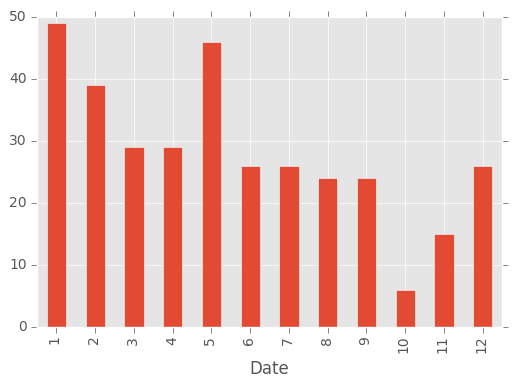

In [11]:
df['Name'].groupby(df.Date.dt.month).count().plot(kind="bar")

In [12]:
location_count = pd.DataFrame({'Count' : df.groupby( ['Location'] ).size()}).reset_index()
location_count

,Location,Count
0,Andrew's home,4
1,Around Bar,5
2,Dima's home,90
3,Engineer pub,22
4,Father's home,6
5,Galina's home,1
6,Galinas's home,2
7,Home,192
8,Irina's home,1
9,Lisopylka,3


In [13]:
players_count = pd.DataFrame({'Count' : df.groupby( ['Players'] ).size()}).reset_index()
players_count

,Players,Count
0,1.0,3
1,2.0,157
2,3.0,66
3,4.0,80
4,5.0,28
5,6.0,5


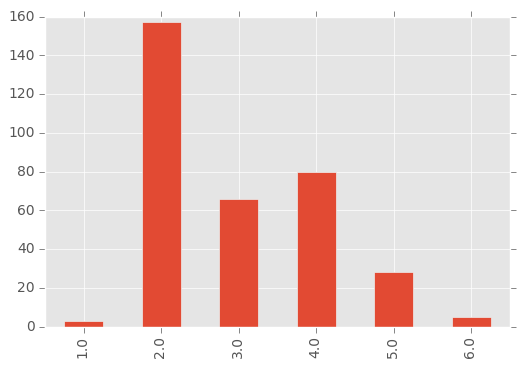

In [14]:
df.Players.value_counts().sort_index().plot(kind='bar')

In [15]:
df2 = get_gamedata(USER, '2015-01-01', '2015-12-31')

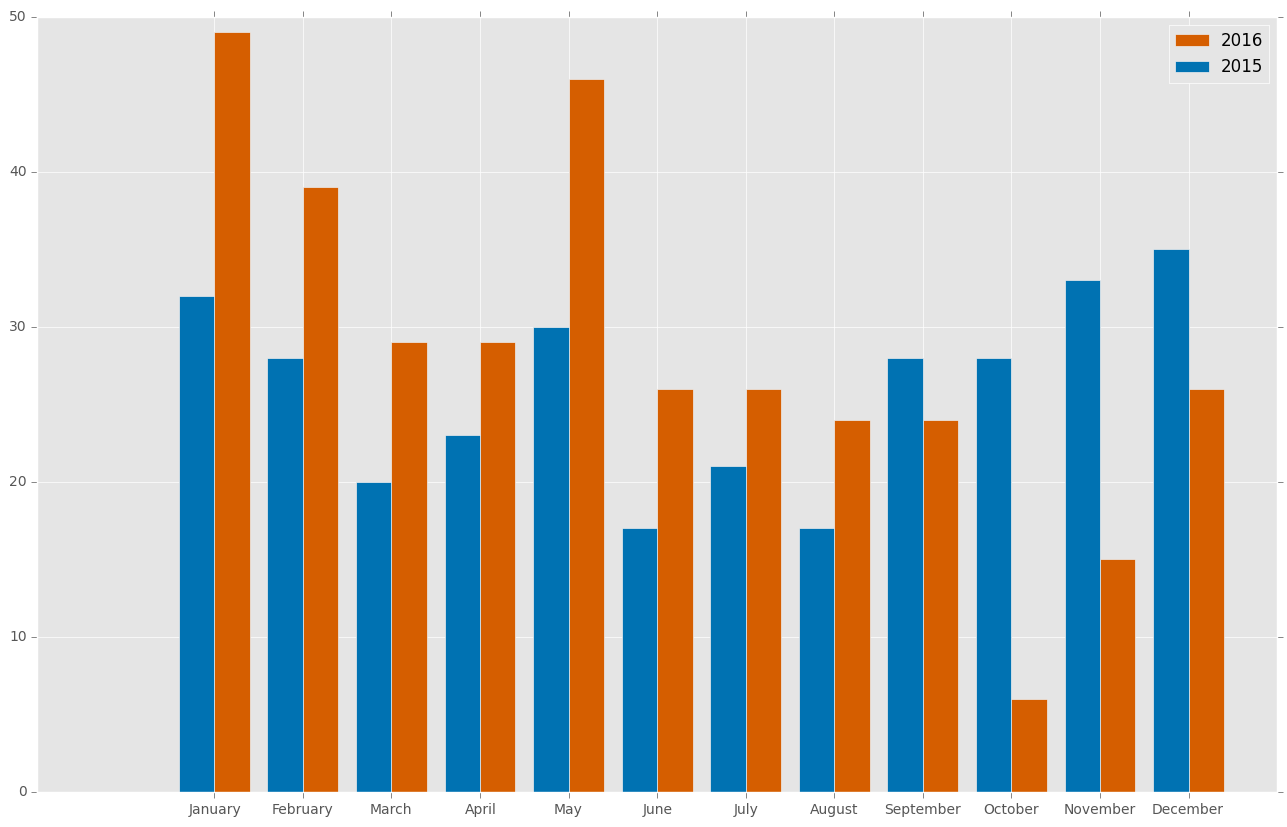

In [16]:
ind = np.arange(12)
width = 0.2

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)

y1 = df['Name'].groupby(df.Date.dt.month).count()
y2 = df2['Name'].groupby(df2.Date.dt.month).count()

bar1 = ax.bar(ind+width, y1,width*2,color="#D55E00",align='center')
bar2 = ax.bar(ind-width, y2,width*2,color="#0072B2",align='center')
ax.set_xticks(ind)
ax.set_xticklabels( [calendar.month_name[i] for i in range(1,13)] )
ax.legend( (bar1[0], bar2[0]), ('2016', '2015') )
plt.show()

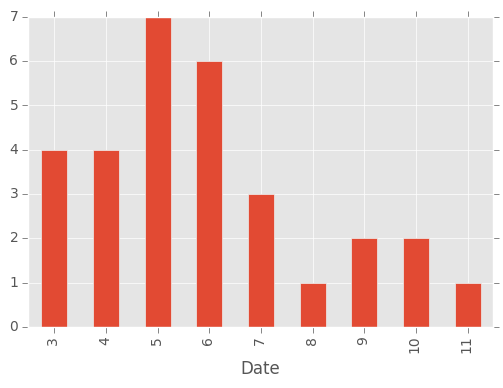

In [17]:
rtfg = df[(df.Name == 'Race for the Galaxy')]
rtfg['Name'].groupby(rtfg.Date.dt.month).count().plot(kind="bar")

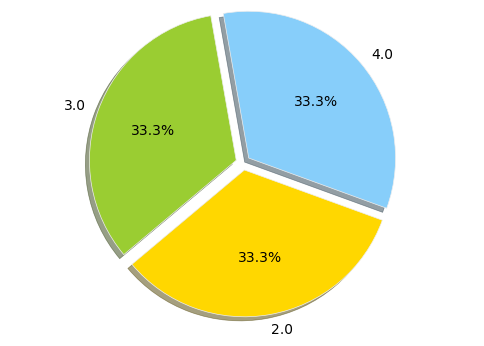

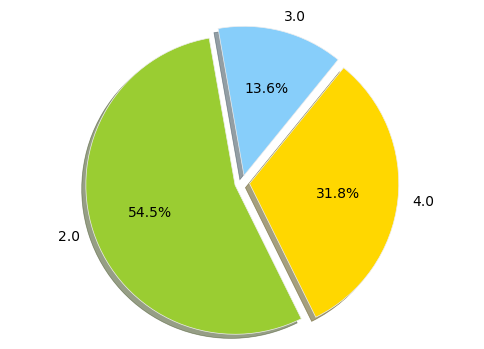

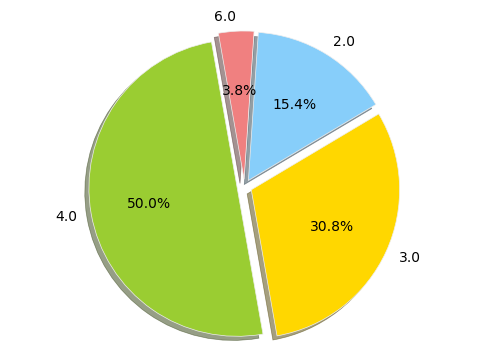

In [18]:
plt.figure(1)
game = df[(df.Name == 'Race for the Galaxy')]
labels = game.Players.value_counts().index.tolist()
players = game.Players.value_counts(normalize=True).tolist()
colors = ['yellowgreen', 'gold', 'lightskyblue']
explode = (0.05, 0.05, 0.05)

plt.pie(players, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=100)
plt.axis('equal')

plt.figure(2)
game = df[(df.Name == 'Bruges')]
labels = game.Players.value_counts().index.tolist()
players = game.Players.value_counts(normalize=True).tolist()
colors = ['yellowgreen', 'gold', 'lightskyblue']
explode = (0.05, 0.05, 0.05)

plt.pie(players, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=100)
plt.axis('equal')

plt.figure(3)
game = df[(df.Name == 'Mysterium')]
labels = game.Players.value_counts().index.tolist()
players = game.Players.value_counts(normalize=True).tolist()
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
explode = (0.05, 0.05, 0.05, 0.05)

plt.pie(players, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=100)
plt.axis('equal')

plt.show()

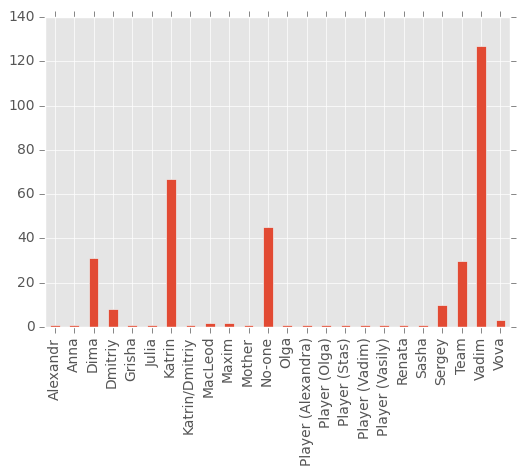

In [19]:
df.Winner.value_counts().sort_index().plot(kind='bar')

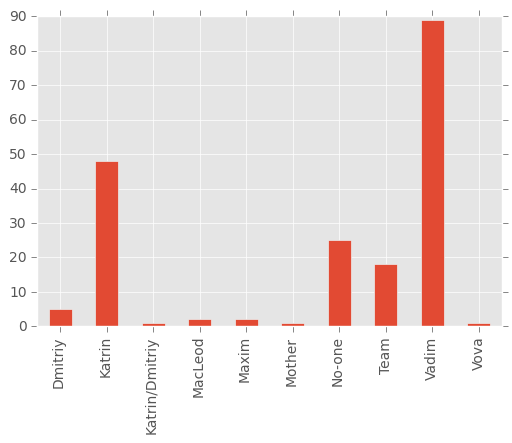

In [20]:
df[(df.Location == 'Home')].Winner.value_counts().sort_index().plot(kind='bar')

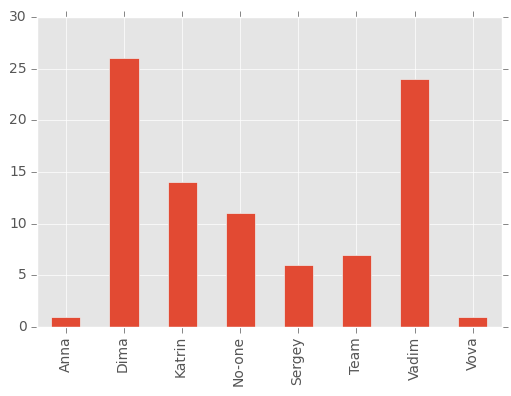

In [21]:
df[(df.Location == "Dima's home")].Winner.value_counts().sort_index().plot(kind='bar')